### Abstract

The objective is to choose the best model for a given data, thus we need to make several models  with a portion of the data and evaluating the best model possible by choosing the one with the lowest SSE. After choosing the best model is necessary to create a new model with all training data avaiable in order to create outputs for the real data.

# Import Libraries

In [141]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures,  StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from tqdm import tqdm

# Import Train Data

In [166]:
N_list = 500
X_import = np.load("data/Xtrain_Regression1.npy")
Y_import = np.load("data/Ytrain_Regression1.npy")
# create global functions to store the splitted data
X_train,Y_train,X_test,Y_test, X_train_s, X_test_s,Y_train_s,Y_test_s = [], [], [], [], [], [], [], []

for i in range(N_list):
    result = train_test_split(X_import, Y_import, test_size=0.2)
    X_train.append(result[0])
    X_test.append(result[1])
    Y_train.append(result[2])
    Y_test.append(result[3])

    x_import = StandardScaler().fit_transform(X_import)
    result2 = train_test_split(x_import, Y_import, test_size=0.2)
    X_train_s.append(result[0])
    X_test_s.append(result[1])
    Y_train_s.append(result[2])
    Y_test_s.append(result[3])

# Essencial Functions

In [143]:
def split_data(x_import,y_import,test_siz):
    '''Splits the data according to the test_siz fraction'''
    x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz)
    return (x_train,y_train,x_test,y_test)


def calc_SSE(y_pred,y):
    '''Calculates the SSE from the predicted data'''
    #return np.sum((y_pred - y)**2)
    return mean_squared_error(y_pred,y)*np.shape(y)[0]

def beta_from_model(model):
    '''Returns the complete beta matrix from the model'''
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta 

# Linear Model

In [158]:
def linear_model(x, y):
    '''Creates and returns a simple linear regression model of order 1'''
    LR = LinearRegression()
    LR.fit(x,y)
    return LR

def test_linear_model(x_train,y_train,x_test,y_test,iters):
    '''Tests the linear model returning a simple SSE value'''

    SSE_lst = []

    for i in range(iters):
        refresh_data(0.2)
        model_sl = linear_model(X_train, Y_train)
        y_pred = model_sl.predict(X_test)
        SSE_lst.append(calc_SSE(y_pred, Y_test))

    SSE_avg = np.mean(SSE_lst)
    SSE_std = np.std(SSE_lst)

    return(SSE_avg,SSE_std)

SSE_lin = test_linear_model(X_train,Y_train,X_test,Y_test,500)
print("Average SSE :", SSE_lin[0], "+/-", SSE_lin[1])

Average SSE : 0.2519719131841059 +/- 0.06636573317181967


# Polynomial Model

SSE order 1 : 0.25657960483408626 +/- 0.06529901227072529
SSE order 2 : 9.812499286788134 +/- 24.163479414427066
SSE order 3 : 30.822735043333072 +/- 11.82438675817548
SSE order 4 : 82.96904508565211 +/- 39.738603140088486


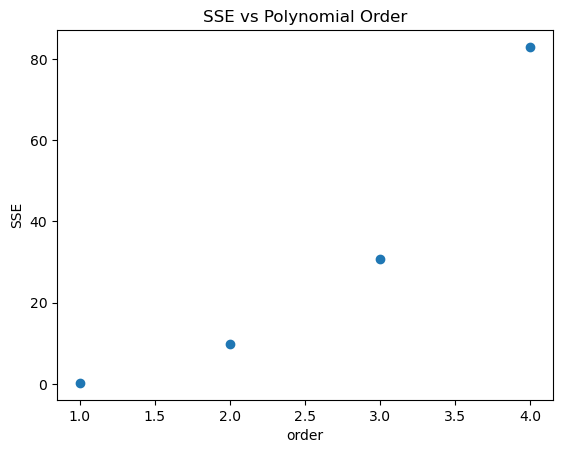

In [145]:
def polynomial_model(x, y, deg):
    '''Creates the polynomial model'''

    poly = PolynomialFeatures(degree=deg, include_bias=True)  
    poly_features = poly.fit_transform(x)  
    poly_reg_model = LinearRegression()  
    poly_reg_model.fit(poly_features, y)
    return poly_reg_model, poly

def test_polynomial_model(deg_max,iters,show_plots=True):
    '''Tests the polynomial model up to deg_max'''

    order_list, SSE, SSE_plt = [i for i in range(1,deg_max+1)], [], []

    def get_avg_sse(i):
        '''Returns the average SSE for a given polynomial degree'''
        SSE_lst = []
        for s in range(1,iters):
            refresh_data(0.2)
            (model,poly) = polynomial_model(X_train,Y_train,i)
            x_test_trans = poly.transform(X_test)
            y_pred = model.predict(x_test_trans)
            SSE_lst.append(calc_SSE(y_pred,Y_test))
        return [np.mean(SSE_lst), np.std(SSE_lst)]
        

    for i in range(1,deg_max+1):
        SSE.append(get_avg_sse(i))
        SSE_plt.append(SSE[-1][0])
    
    
    if show_plots:
        plt.scatter(order_list, SSE_plt)
        plt.xlabel('order')
        plt.ylabel('SSE')
        plt.title('SSE vs Polynomial Order')
        
        return SSE, plt
    
    else:
        return SSE


SSE_pol, plot_pol = test_polynomial_model(4,500,show_plots=True)
for i in range(len(SSE_pol)):
    print("SSE order",i+1,":",SSE_pol[i][0], "+/-", SSE_pol[i][1])
plot_pol.show()

From the plot above we can see that a first order model is the best

# Ridge Model

In [146]:
def ridge_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, -1, 70)), #At this range is random  -8,8
    #'fit_intercept':[True,False],
    #'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] #,'lbfgs'
    }
    
    model = Ridge()
    search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result

def test_ridge_model(i,pt=True):
    '''This function tests the ridge model'''

    # cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    cv = None
    model = ridge_modelcv(X_train_s[i],Y_train_s[i],cv)
    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test_s[i])
    mse=mean_squared_error(Y_test_s[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

best_alpha_ridge = test_ridge_model(0)[3]

R2: 0.9972048273365989
SSE: 0.14526797902892646
MSE 0.0072633989514463235
Best Hyperparameters: {'alpha': 0.001}


In [147]:
from tqdm import trange

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(N_list):
    best_ridge = test_ridge_model(i,pt=False)

    TestAlpha.append(best_ridge[3])
    TestScore.append(best_ridge[0])
    TestMSE.append(best_ridge[2])
    TestSSE.append(best_ridge[1])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

100%|██████████| 500/500 [03:27<00:00,  2.41it/s]

α   = 0.05278828059311272 ± 0.04427999513180674
R²  = 0.997499528616326 ± 0.00042040456508501826
MSE = 0.012716188701696357 ± 0.0034088764861797097
SSE = 0.2543237740339272 ± 0.0681775297235942


In [148]:
from tqdm import trange

alphalist = np.logspace(start=-3, stop=-1, num=100)
model = RidgeCV(alphas=alphalist)

def test_ridge_model(i,model, pt=True):
    '''This function tests the ridge model'''
    model.fit(X_train_s[i], Y_train_s[i])

    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test_s[i])
    mse=mean_squared_error(Y_test_s[i],y_pred)
    alpha=model.alpha_

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.alpha_)
    return r2, sse, mse, alpha

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(N_list):
    best_ridge = test_ridge_model(i,model,pt=False)

    TestAlpha.append(best_ridge[3])
    TestScore.append(best_ridge[0])
    TestMSE.append(best_ridge[2])
    TestSSE.append(best_ridge[1])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

100%|██████████| 500/500 [00:04<00:00, 100.49it/s]

α   = 0.05862833949350749 ± 0.024792861092375138
R²  = -0.01271335942533134 ± 0.0010017303554914873
MSE = 0.01272230074764597 ± 0.003413892378018902
SSE = 0.2544460149529194 ± 0.06827784756037804


In [149]:
#Change True to False
if True:
    r2,mse = [], []
    for i in range(N_list):
        ridge_model = Ridge(alpha = 0.06) #,fit_intercept = True, solver = 'saga')
        model = ridge_model.fit(X_train_s[i],Y_train_s[i])
        y_pred = model.predict(X_test_s[i])
        r2.append(r2_score(Y_test_s[i],y_pred))
        mse.append(mean_squared_error(Y_test_s[i],y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

Average R2: 0.9976794170625991 +/ 0.0009642825287576996
Average MSE: 0.012717676535491431 +/ 0.0034114044979720926


# Lasso Model

In [154]:
def lasso_modelcv(x,y,cvs):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, 0, 100)), #At this range is random 
    #'fit_intercept':[True,False]
       }
    
    lasso = Lasso()
    search = GridSearchCV(lasso, param, scoring='r2' ,cv = cvs)
    result = search.fit(x, y)
    return result

def test_lasso_model(i,pt=True):
    '''This function tests the ridge model'''

    cv = None
    # cv =RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    model = lasso_modelcv(X_train_s[i],Y_train_s[i],cv)
    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test_s[i])
    mse=mean_squared_error(Y_test_s[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

best_lasso_alpha=test_lasso_model(0)[3]

R2: 0.9972034489005889
SSE: 0.14610631624498896
MSE 0.007305315812249448
Best Hyperparameters: {'alpha': 0.001}


In [155]:
from tqdm import trange

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(100):
    best_lasso = test_lasso_model(i,pt=False)

    TestAlpha.append(best_lasso[3])
    TestScore.append(best_lasso[0])
    TestMSE.append(best_lasso[2])
    TestSSE.append(best_lasso[1])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

α   = 0.003517640500601665 ± 0.0026488692025395727
R²  = 0.9975693987195307 ± 0.00039706522456899675
MSE = 0.012742065074284513 ± 0.0036412701741407667
SSE = 0.25484130148569023 ± 0.07282540348281534


In [159]:
# Test for 1000 runs average -> change False to True
if True:
    r2,mse = [], []
    for i in range(1000):
        X_sc = StandardScaler().fit_transform(X_import)
        X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_import, test_size=0.2)
        lasso_model = Lasso(alpha = best_lasso_alpha ,fit_intercept = True)
        model = lasso_model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        r2.append(r2_score(Y_test,y_pred))
        mse.append(mean_squared_error(Y_test,y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

Average R2: 0.9976623993870164 +/ 0.0009593261735779847
Average MSE: 0.012695673036310135 +/ 0.003460801973200227


# Comparing Linear, Ridge and Lasso

100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


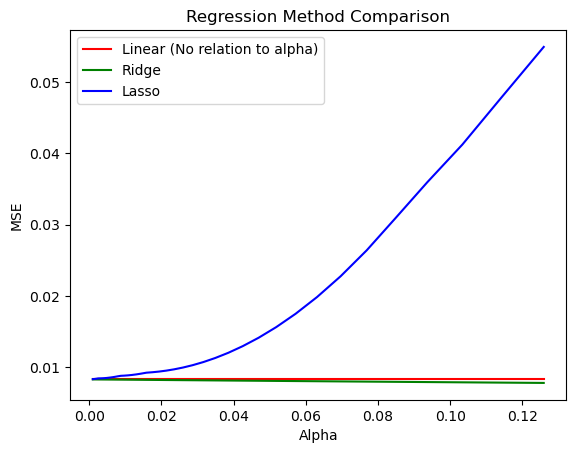

<module 'matplotlib.pyplot' from 'C:\\Users\\Miguel Lopes\\AppData\\Roaming\\Python\\Python38\\site-packages\\matplotlib\\pyplot.py'>

In [168]:
from tqdm import tqdm
def compare_lin_rid_las(alpha_list):
    MSE_ridge, MSE_lasso, MSE_linear = [], [], []
    for alpha in tqdm(alpha_list):

        for i in range(N_list):
         
            MSE_ridge_i, MSE_lasso_i, MSE_linear_i = [], [], []
            #Linear
            linear = LinearRegression()
            linear.fit(X_train[i],Y_train[i])
            y_linear = linear.predict(X_test[i])
            MSE_linear_i.append(mean_squared_error(Y_test[i],y_linear))

            #Ridge
            ridge = Ridge(alpha=alpha)
            ridge_model = ridge.fit(X_train_s[i],Y_train_s[i])
            y_ridge = ridge_model.predict(X_test_s[i])
            MSE_ridge_i.append(mean_squared_error(Y_test_s[i],y_ridge))

            # Lasso
            lasso = Lasso(alpha = alpha)
            lasso_model = lasso.fit(X_train_s[i],Y_train_s[i])
            y_lasso = lasso_model.predict(X_test_s[i])
            MSE_lasso_i.append(mean_squared_error(Y_test_s[i],y_lasso))

        MSE_linear.append(np.mean(MSE_linear_i))
        MSE_ridge.append(np.mean(MSE_ridge_i))
        MSE_lasso.append(np.mean(MSE_lasso_i))

    plt.plot(alpha_list, MSE_linear, color='r', label='Linear (No relation to alpha)')
    plt.plot(alpha_list,MSE_ridge, color='g', label='Ridge')
    plt.plot(alpha_list,MSE_lasso,  color='b', label='Lasso')

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title("Regression Method Comparison")
    
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    
    # To load the display window
    plt.show()

compare_lin_rid_las(np.logspace(-3, -0.9, 50))

In [ ]:
print(MSE_ridge)

As we can see, we have a value for alpha where Ridge has the lowest MSE and consequently SSE

## Conclusions

Let's assume Ridge is the best model due to a marginal difference in SSE

In [ ]:
x_eval_import = np.load("data/Xtest_Regression1.npy")
x_eval_s = StandardScaler().fit_transform(x_eval_import)
X_import_s = StandardScaler().fit_transform(X_import)
ridge = Ridge(alpha=best_alpha_ridge)
ridge_model = ridge.fit(X_import_s,Y_import)
y_ridge = ridge_model.predict(x_eval_s)


NameError: name 'ridge_model' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25889058-66de-44c8-ad64-ee695f6c1052' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>